# Map-based simulation for differential pointing per frequency channel

## Here, we introduce how to assess differential pointing systematics by the map-based simulation in the case of a single frequency channel.


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sbm
from sbm import Field, ScanFields, SignalFields, plot_maps

In [2]:
# Load single detector map
ch_id = 0
channel = sbm.channel_list[ch_id]

# It assumes that base_path has been installed to SBM by install_db()
sf_ch = ScanFields.load_channel(channel)
print("Channel: ", channel)

Channel:  L1-040


In [3]:
# Prepare input map and transfer function
fiducial_map = hp.read_map("../maps/cmb_0000_nside_128_seed_33.fits", field=(0,1,2)) * 1e6
fwhm = np.deg2rad(sbm.fwhms[ch_id]/60.)
input_map = hp.smoothing(fiducial_map, fwhm)
nside = hp.get_nside(input_map[0])
lmax = 3*nside-1
bl = hp.gauss_beam(fwhm, lmax=lmax, pol=True)

In [4]:
# Make gain value per detector
# If random is False, all detectors have the same gain value
# If random is True, gain values are randomly generated with Gaussian distribution
random = False

if random == False:
    rho_T = np.ones(sf_ch.ndet) * np.deg2rad(1/60.)
    rho_B = np.ones(sf_ch.ndet) * np.deg2rad(0)
    chi_T = np.ones(sf_ch.ndet) * 0.0
    chi_B = np.ones(sf_ch.ndet) * 0.0
else:
    sigma = np.deg2rad(1/60.)
    np.random.seed(1234)
    rho_T = np.random.normal(loc=0.0, scale=sigma, size=sf_ch.ndet)
    rho_B = np.random.normal(loc=0.0, scale=sigma, size=sf_ch.ndet)
    chi_T = np.random.normal(loc=0.0, scale=sigma, size=sf_ch.ndet)
    chi_B = np.random.normal(loc=0.0, scale=sigma, size=sf_ch.ndet)
mdim = 2
total_field = ScanFields.sim_diff_pointing_channel(channel, mdim, input_map, rho_T, rho_B, chi_T, chi_B)

Here, we inpose $(\rho,\chi)=(1,0)$ arcmin offset.

We can solve given lenear system by `.solve` method as bellow:


In [5]:
# This method is used when we have already  prepared the signal field detector by detector.
output_map = total_field.solve()
residual = input_map - output_map

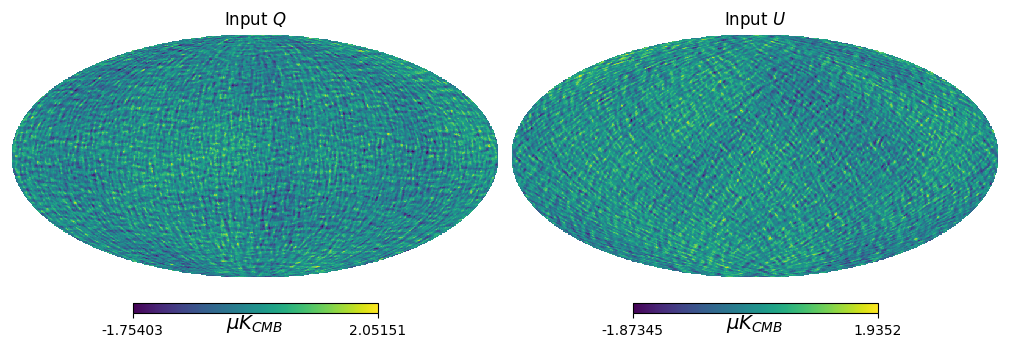

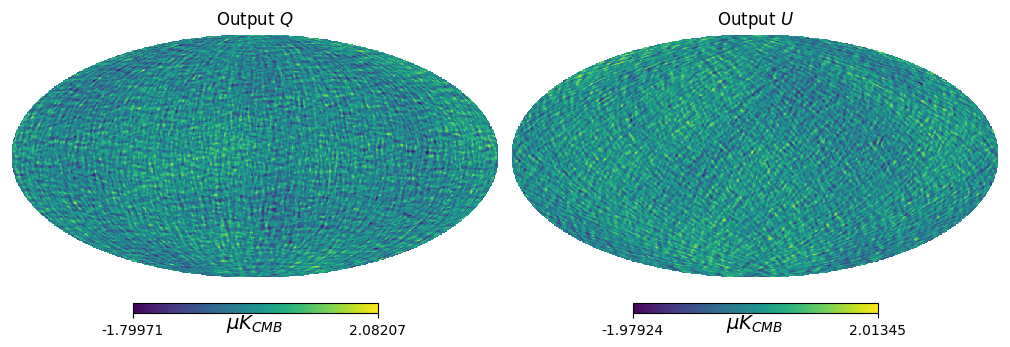

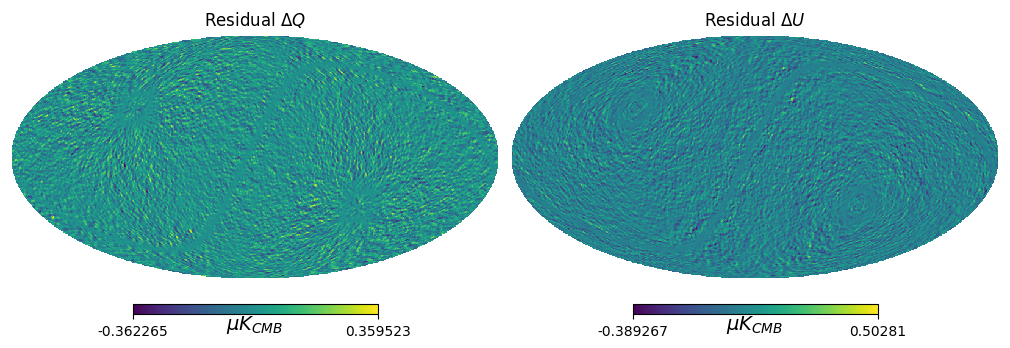

In [6]:
# Show obtained maps
plot_maps(mdim, input_map, output_map, residual)

# Let's check the power spectra

The green line shows systematics power spectrum, i.e., $\Delta C_\ell^{BB}$, which is obtained by residual map.

Althogh the green line is providing an exact solution which agrees with the binning map-making, we can perform an analitical estimation without doing the map-making.

The red line $\Delta C_{\ell, Ana}^{BB}$ is simulated by

$$
\Delta C_{\ell, Ana}^{BB} = \frac{1}{8} (\langle|{}_{1}\tilde{h}|^2\rangle + \langle|{}_{3}\tilde{h}|^2\rangle)~\rho^2~\ell^2~C_{\ell}^{TT}
$$

where $\langle|{}_{n}\tilde{h}|^2\rangle$ represents the entire sky average of the spin-n cross-link.

About the analitical discription, see [C.G.R. Wallis et al.](https://arxiv.org/abs/1604.02290).


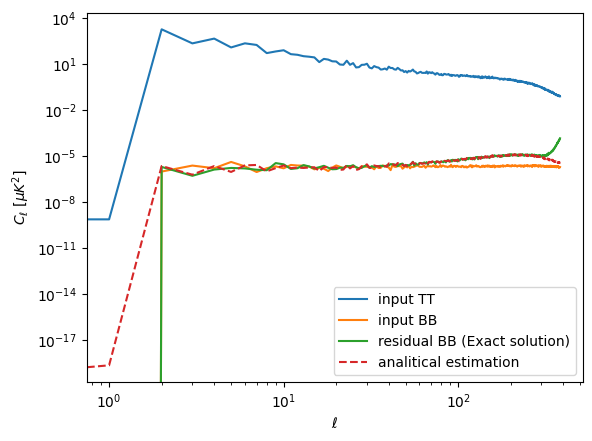

In [7]:
fiducial_cl = hp.anafast(fiducial_map)
res_cl = hp.anafast(residual)

ell = np.arange(len(fiducial_cl[0]))
xlink1_mean = np.mean(np.abs(total_field.get_xlink(1,0))**2)
xlink3_mean = np.mean(np.abs(total_field.get_xlink(3,0))**2)
ana = (1/8) * (xlink1_mean + xlink3_mean) * fiducial_cl[0] * rho_T[0]**2 * ell**2

plt.plot(fiducial_cl[0], label="input TT")
plt.plot(fiducial_cl[2], label="input BB")
plt.plot(res_cl[2] / bl[:,2]**2, label="residual BB (Exact solution)")
plt.plot(ana, "--", label="analitical estimation")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell ~ [\mu K^2]$")
plt.xscale("log")
plt.yscale("log")
plt.legend();